# Neural networks with PyTorch

Deep learning networks tend to be massive with dozens or hundreds of layers, that's where the term "deep" comes from. You can build one of these deep networks using only weight matrices , but in general it's very cumbersome and difficult to implement. PyTorch has a nice module `nn` that provides a nice way to efficiently build large neural networks.

In [63]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np
import torch
import matplotlib.pyplot as plt


Now we're going to build a larger network that can solve a (formerly) difficult problem, identifying text in an image. Here we'll use the MNIST dataset which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below

<img src='assets/mnist.png'>

Our goal is to build a neural network that can take one of these images and predict the digit in the image.

First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us.

In [64]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform=transforms.Compose([transforms.ToTensor(),
                             transforms.Normalize((0.5,),(0.5,))])

trainset=datasets.MNIST('~/.pytorch/MNIST_data/',train=True,download=True,transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=64)

You'll notice I created the trainloader with a batch size of 64, and shuffle=True. The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a batch. And shuffle=True tells it to shuffle the dataset every time we start going through the data loader again. But here I'm just grabbing the first batch so we can check out the data. We can see below that images is just a tensor with size (64, 1, 28, 28). So, 64 images per batch, 1 color channel, and 28x28 images.

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


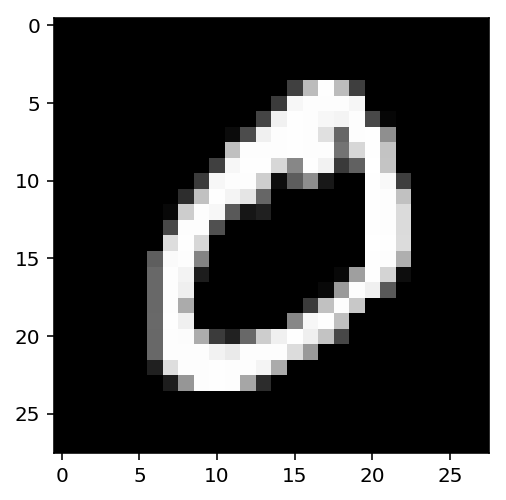

In [65]:
images, labels =next(iter(trainloader))
print(type(images))
print(images.shape)
print(labels.shape)
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

## Building networks with PyTorch

PyTorch provides a module `nn` that makes building networks much simpler.Lets build a network with 784 inputs, 256 hidden units, 10 output units and a softmax output.

In [66]:
from torch import nn
import torch.nn.functional as F

In [72]:
class MNISTnetwort(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(784,128)
        self.fc2=nn.Linear(128,64)
        self.fc3=nn.Linear(64,10)
        
        
    def forward(self,x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.log_softmax(self.fc3(x),dim=1)
        
        return x
        

In [73]:
model=MNISTnetwort()
model

MNISTnetwort(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Forward pass

Now that we have a network, let's see what happens when we pass in an image.

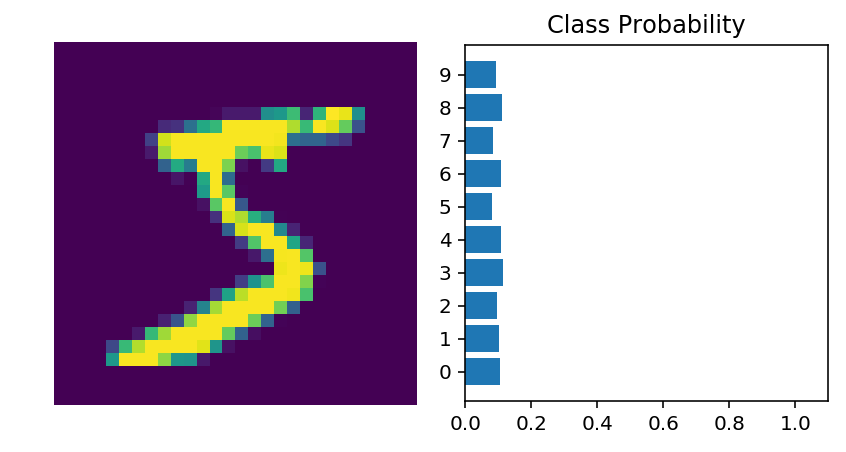

In [69]:
images, labesl =next(iter(trainloader))

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
img = images[0].view(1, 784)

# Forward pass through the network

logps = model.forward(img)
ps=torch.exp(logps)
ps=ps.data.numpy().squeeze()
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
ax1.axis('off')
ax2.barh(np.arange(10), ps)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

As you can see above, our network has basically no idea what this digit is. It's because we haven't trained it yet, all the weights are random!

# Training Neural Networks

The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="assets/function_approx.png" width=500px>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

In [74]:
from torch import optim
criterion=nn.NLLLoss()
optimizer=optim.SGD(model.parameters(),lr=0.03)

In [75]:
epochs=5

for epoch in range(epochs):
    running_loss=0
    for images, labels in trainloader:
        images=images.view(images.shape[0],-1)
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
    

        out=model.forward(images)
        loss=criterion(out,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.5960429528755928
Training loss: 0.27933784147827767
Training loss: 0.21677189445974968
Training loss: 0.1761159099279039
Training loss: 0.14850387002365278


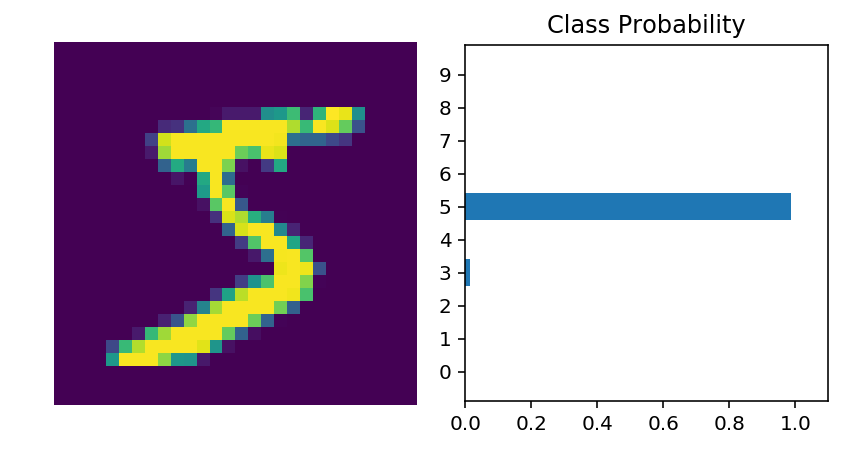

In [76]:
images, labesl =next(iter(trainloader))

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
img = images[0].view(1, 784)

# Forward pass through the network

logps = model.forward(img)
ps=torch.exp(logps)
ps=ps.data.numpy().squeeze()
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
ax1.axis('off')
ax2.barh(np.arange(10), ps)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

Now our network is brilliant. It can accurately predict the digits in our images.